 # PRÉ-PROCESSAMENTO DOS DADOS

 Este notebook implementa as estratégias de pré-processamento identificadas na análise exploratória

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("CARREGANDO DADOS E RESULTADOS DA ANÁLISE EXPLORATÓRIA")
print("=" * 80)


CARREGANDO DADOS E RESULTADOS DA ANÁLISE EXPLORATÓRIA


In [2]:
df_train = pd.read_csv('../data/raw/train.csv')

print(f"\n✓ Dados carregados:")
print(f"   - Treino: {df_train.shape}")



✓ Dados carregados:
   - Treino: (891, 12)


In [3]:
with open('../results/eda_results.pkl', 'rb') as f:
    eda_results = pickle.load(f)

print(f"\n✓ Resultados da EDA carregados:")
print(f"   - Features numéricas: {len(eda_results['numeric_features'])}")
print(f"   - Features categóricas: {len(eda_results['categorical_features'])}")
print(f"   - Data da análise: {eda_results['analysis_date']}")



✓ Resultados da EDA carregados:
   - Features numéricas: 7
   - Features categóricas: 5
   - Data da análise: 2025-12-07 16:08:19


 # 1. IMPUTAÇÃO DE VALORES AUSENTES

In [4]:
print("\n📊 Imputando Age por grupo (Pclass + Sex)...")

# Calcula medianas por grupo
age_medians = df_train.groupby(['Pclass', 'Sex'])['Age'].median()
print("\nMedianas de Age por grupo:")
print(age_medians)

# Função para imputar age
def impute_age(df, age_medians):
    df = df.copy()
    for (pclass, sex), median_age in age_medians.items():
        mask = (df['Pclass'] == pclass) & (df['Sex'] == sex) & (df['Age'].isnull())
        df.loc[mask, 'Age'] = median_age
    return df

# Aplica imputação
df_train = impute_age(df_train, age_medians)

print(f"\n✓ Age imputado")
print(f"   - Missing restante: {df_train['Age'].isnull().sum()}")



📊 Imputando Age por grupo (Pclass + Sex)...

Medianas de Age por grupo:
Pclass  Sex   
1       female    35.0
        male      40.0
2       female    28.0
        male      30.0
3       female    21.5
        male      25.0
Name: Age, dtype: float64

✓ Age imputado
   - Missing restante: 0


In [5]:
print("\n📊 Imputando Embarked pela moda...")

embarked_mode = df_train['Embarked'].mode()[0]
print(f"   Moda de Embarked: {embarked_mode}")

df_train['Embarked'].fillna(embarked_mode, inplace=True)

print(f"\n✓ Embarked imputado")
print(f"   - Missing restante: {df_train['Embarked'].isnull().sum()}")



📊 Imputando Embarked pela moda...
   Moda de Embarked: S

✓ Embarked imputado
   - Missing restante: 0


 # 2. FEATURE ENGINEERING

In [6]:
print("\n🔧 Criando FamilySize...")

df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1

print("   Distribuição de FamilySize:")
print(df_train['FamilySize'].value_counts().sort_index())



🔧 Criando FamilySize...
   Distribuição de FamilySize:
FamilySize
1     537
2     161
3     102
4      29
5      15
6      22
7      12
8       6
11      7
Name: count, dtype: int64


In [7]:
print("\n🔧 Criando IsAlone...")

df_train['IsAlone'] = (df_train['FamilySize'] == 1).astype(int)

print(f"   Pessoas viajando sozinhas: {df_train['IsAlone'].sum()} ({df_train['IsAlone'].sum()/len(df_train)*100:.1f}%)")



🔧 Criando IsAlone...
   Pessoas viajando sozinhas: 537 (60.3%)


In [8]:
print("\n🔧 Extraindo Title de Name...")

def extract_title(df):
    df = df.copy()
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    
    # Mapeamento de títulos
    title_mapping = {
        'Mr': 'Mr',
        'Miss': 'Miss',
        'Mrs': 'Mrs',
        'Master': 'Master',
        'Dr': 'Rare',
        'Rev': 'Rare',
        'Col': 'Rare',
        'Major': 'Rare',
        'Mlle': 'Miss',
        'Mme': 'Mrs',
        'Don': 'Rare',
        'Dona': 'Rare',
        'Lady': 'Rare',
        'Countess': 'Rare',
        'Jonkheer': 'Rare',
        'Sir': 'Rare',
        'Capt': 'Rare',
        'Ms': 'Miss'
    }
    
    df['Title'] = df['Title'].map(title_mapping)
    df['Title'].fillna('Rare', inplace=True)
    
    return df

df_train = extract_title(df_train)

print("   Distribuição de Title:")
print(df_train['Title'].value_counts())



🔧 Extraindo Title de Name...
   Distribuição de Title:
Title
Mr        517
Miss      185
Mrs       126
Master     40
Rare       23
Name: count, dtype: int64


In [9]:
print("\n🔧 Criando HasCabin...")

df_train['HasCabin'] = df_train['Cabin'].notna().astype(int)

print(f"   Passageiros com cabine: {df_train['HasCabin'].sum()} ({df_train['HasCabin'].sum()/len(df_train)*100:.1f}%)")



🔧 Criando HasCabin...
   Passageiros com cabine: 204 (22.9%)


In [10]:
print("\n🔧 Extraindo Deck de Cabin...")

df_train['Deck'] = df_train['Cabin'].str[0]
df_train['Deck'].fillna('U', inplace=True)

print("   Distribuição de Deck:")
print(df_train['Deck'].value_counts().sort_index())



🔧 Extraindo Deck de Cabin...
   Distribuição de Deck:
Deck
A     15
B     47
C     59
D     33
E     32
F     13
G      4
T      1
U    687
Name: count, dtype: int64


In [11]:
print("\n🔧 Criando AgeGroup...")

df_train['AgeGroup'] = pd.cut(df_train['Age'], 
                               bins=[0, 12, 18, 60, 100],
                               labels=['Child', 'Teen', 'Adult', 'Senior'])

print("   Distribuição de AgeGroup:")
print(df_train['AgeGroup'].value_counts())



🔧 Criando AgeGroup...
   Distribuição de AgeGroup:
AgeGroup
Adult     730
Teen       70
Child      69
Senior     22
Name: count, dtype: int64


In [12]:
print("\n🔧 Criando FarePerPerson...")

df_train['FarePerPerson'] = df_train['Fare'] / df_train['FamilySize']

print(f"   FarePerPerson - Média: {df_train['FarePerPerson'].mean():.2f}, Mediana: {df_train['FarePerPerson'].median():.2f}")



🔧 Criando FarePerPerson...
   FarePerPerson - Média: 19.92, Mediana: 8.30


In [13]:
print("\n✅ FEATURES CRIADAS:")
new_features = ['FamilySize', 'IsAlone', 'Title', 'HasCabin', 'Deck', 'AgeGroup', 'FarePerPerson']
print(f"   Total: {len(new_features)} novas features")
for feat in new_features:
    print(f"   - {feat}")



✅ FEATURES CRIADAS:
   Total: 7 novas features
   - FamilySize
   - IsAlone
   - Title
   - HasCabin
   - Deck
   - AgeGroup
   - FarePerPerson


 # 3. CODIFICAÇÃO DE VARIÁVEIS CATEGÓRICAS

In [14]:
print("\n📋 Selecionando features para o modelo...")

features_to_use = [
    'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
    'FamilySize', 'IsAlone', 'HasCabin', 'FarePerPerson',
    'Sex', 'Embarked', 'Title', 'Deck', 'AgeGroup'
]

print(f"\n✓ Features selecionadas: {len(features_to_use)}")



📋 Selecionando features para o modelo...

✓ Features selecionadas: 14


In [15]:
categorical_features = ['Sex', 'Embarked', 'Title', 'Deck', 'AgeGroup']
numerical_features = [f for f in features_to_use if f not in categorical_features]

print(f"\n📊 Tipos de features:")
print(f"   - Numéricas: {len(numerical_features)}")
print(f"   - Categóricas: {len(categorical_features)}")



📊 Tipos de features:
   - Numéricas: 9
   - Categóricas: 5


In [16]:
print("\n🔢 Aplicando Label Encoding...")

label_encoders = {}

for feat in categorical_features:
    le = LabelEncoder()
    df_train[feat + '_encoded'] = le.fit_transform(df_train[feat])
    label_encoders[feat] = le
    print(f"   ✓ {feat}: {len(le.classes_)} classes")

features_encoded = numerical_features + [f + '_encoded' for f in categorical_features]

print(f"\n✓ Total de features após encoding: {len(features_encoded)}")



🔢 Aplicando Label Encoding...
   ✓ Sex: 2 classes
   ✓ Embarked: 3 classes
   ✓ Title: 5 classes
   ✓ Deck: 9 classes
   ✓ AgeGroup: 4 classes

✓ Total de features após encoding: 14


 # 4. SPLIT TREINO/VALIDAÇÃO

In [17]:
print("\n🎯 Separando X e y...")

X = df_train[features_encoded]
y = df_train['Survived']

print(f"\n✓ Dataset completo:")
print(f"   - X: {X.shape}")
print(f"   - y: {y.shape}")



🎯 Separando X e y...

✓ Dataset completo:
   - X: (891, 14)
   - y: (891,)


In [18]:
print("\n🔀 Dividindo em treino (80%) e validação (20%)...")

X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"\n✓ Split realizado:")
print(f"   - X_train: {X_train.shape} (80%)")
print(f"   - X_val: {X_val.shape} (20%)")

print(f"\n   Distribuição do target:")
print(f"   - Treino: {pd.Series(y_train).value_counts().to_dict()}")
print(f"   - Validação: {pd.Series(y_val).value_counts().to_dict()}")



🔀 Dividindo em treino (80%) e validação (20%)...

✓ Split realizado:
   - X_train: (712, 14) (80%)
   - X_val: (179, 14) (20%)

   Distribuição do target:
   - Treino: {0: 439, 1: 273}
   - Validação: {0: 110, 1: 69}


In [19]:
print("\n🔍 Verificando valores ausentes...")

missing_train = X_train.isnull().sum().sum()
missing_val = X_val.isnull().sum().sum()

if missing_train == 0 and missing_val == 0:
    print("   ✅ Nenhum valor ausente!")
else:
    print(f"   ⚠️ Encontrados: Treino={missing_train}, Val={missing_val}")



🔍 Verificando valores ausentes...
   ✅ Nenhum valor ausente!


 # 5. SALVAR DADOS PROCESSADOS

In [20]:
processed_dir = '../data/processed'
os.makedirs(processed_dir, exist_ok=True)


In [21]:
print("\n💾 Salvando datasets processados...")

X_train.to_csv(os.path.join(processed_dir, 'X_train.csv'), index=False)
X_val.to_csv(os.path.join(processed_dir, 'X_val.csv'), index=False)
pd.Series(y_train).to_csv(os.path.join(processed_dir, 'y_train.csv'), index=False, header=['Survived'])
pd.Series(y_val).to_csv(os.path.join(processed_dir, 'y_val.csv'), index=False, header=['Survived'])

print("✓ Datasets salvos em data/processed/")



💾 Salvando datasets processados...
✓ Datasets salvos em data/processed/


In [22]:
preprocessing_info = {
    'features_used': features_to_use,
    'features_encoded': features_encoded,
    'categorical_features': categorical_features,
    'numerical_features': numerical_features,
    'label_encoders': label_encoders,
    'age_medians': age_medians,
    'embarked_mode': embarked_mode,
    'train_shape': X_train.shape,
    'val_shape': X_val.shape,
    'preprocessing_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open(os.path.join(processed_dir, 'preprocessing_info.pkl'), 'wb') as f:
    pickle.dump(preprocessing_info, f)

print("✓ Metadados salvos: preprocessing_info.pkl")


✓ Metadados salvos: preprocessing_info.pkl


 # 6. VISUALIZAÇÕES FINAIS


✓ Visualização salva: 05_features_processadas.png


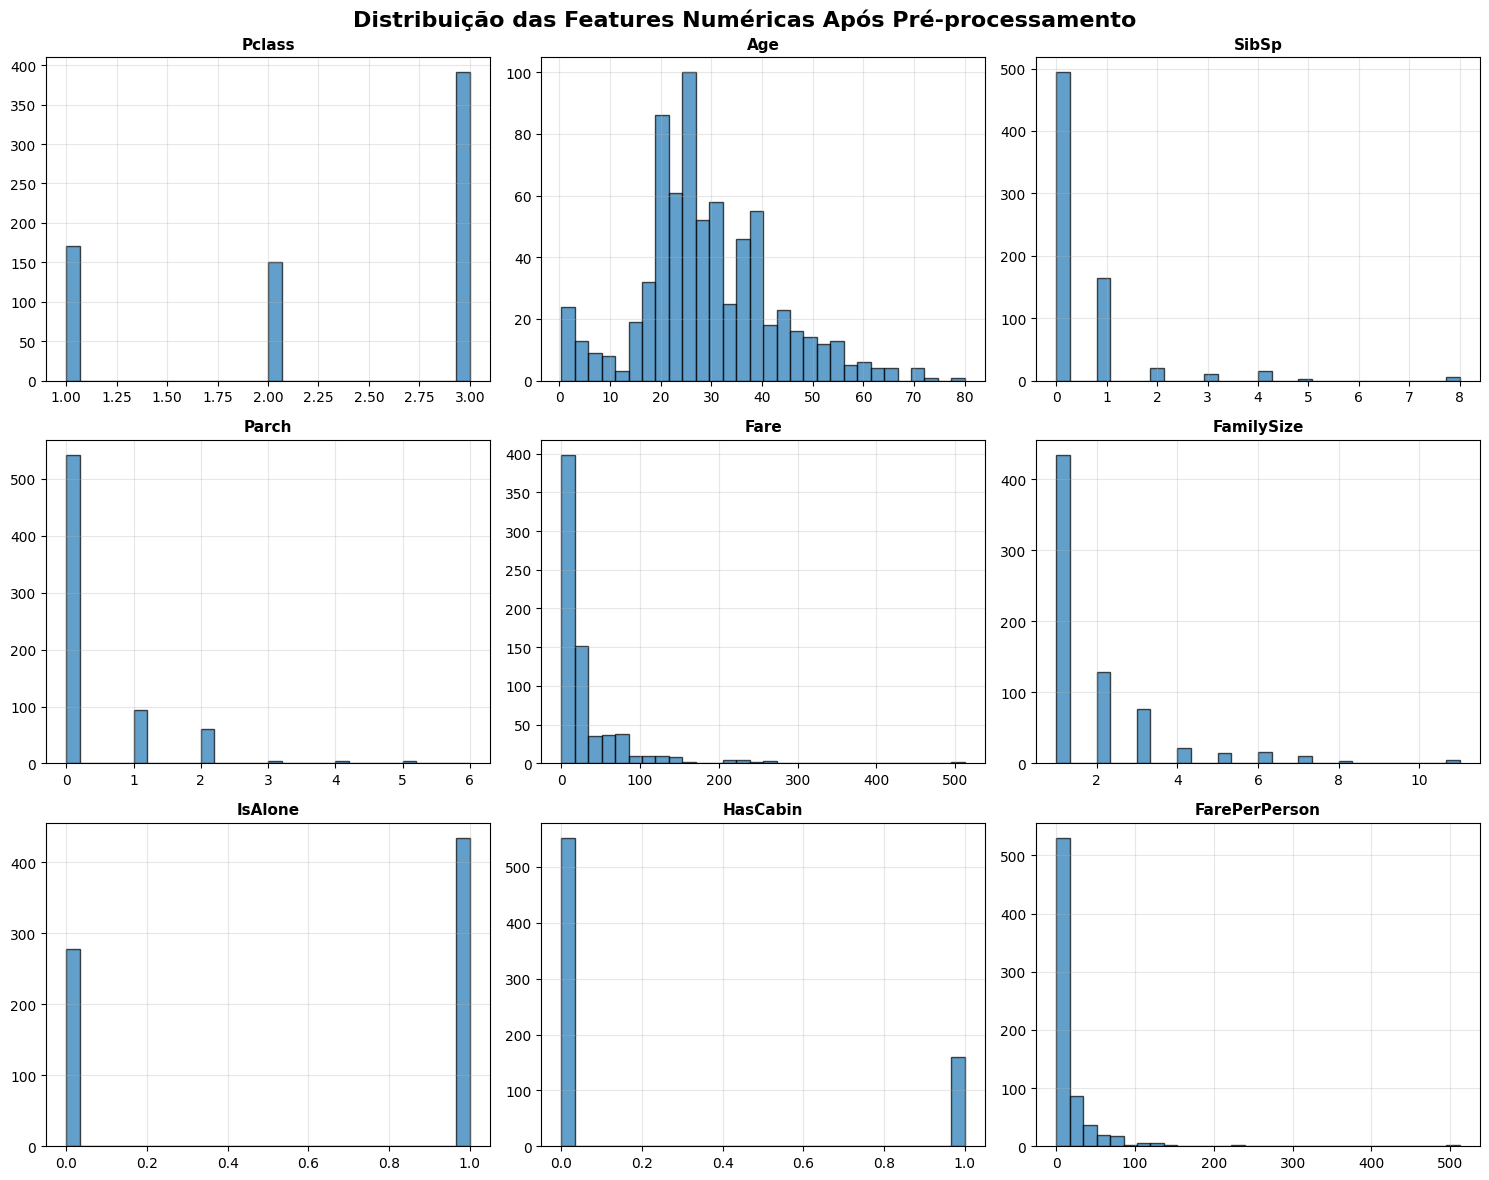

In [23]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle('Distribuição das Features Numéricas Após Pré-processamento', fontsize=16, fontweight='bold')

axes = axes.flatten()
for idx, col in enumerate(numerical_features):
    if idx < len(axes):
        X_train[col].hist(bins=30, ax=axes[idx], edgecolor='black', alpha=0.7)
        axes[idx].set_title(col, fontsize=11, fontweight='bold')
        axes[idx].grid(True, alpha=0.3)

for idx in range(len(numerical_features), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
figures_dir = '../results/figures'
plt.savefig(os.path.join(figures_dir, '05_features_processadas.png'), dpi=300, bbox_inches='tight')
print("\n✓ Visualização salva: 05_features_processadas.png")


✓ Matriz de correlação salva: 06_correlacao_processadas.png


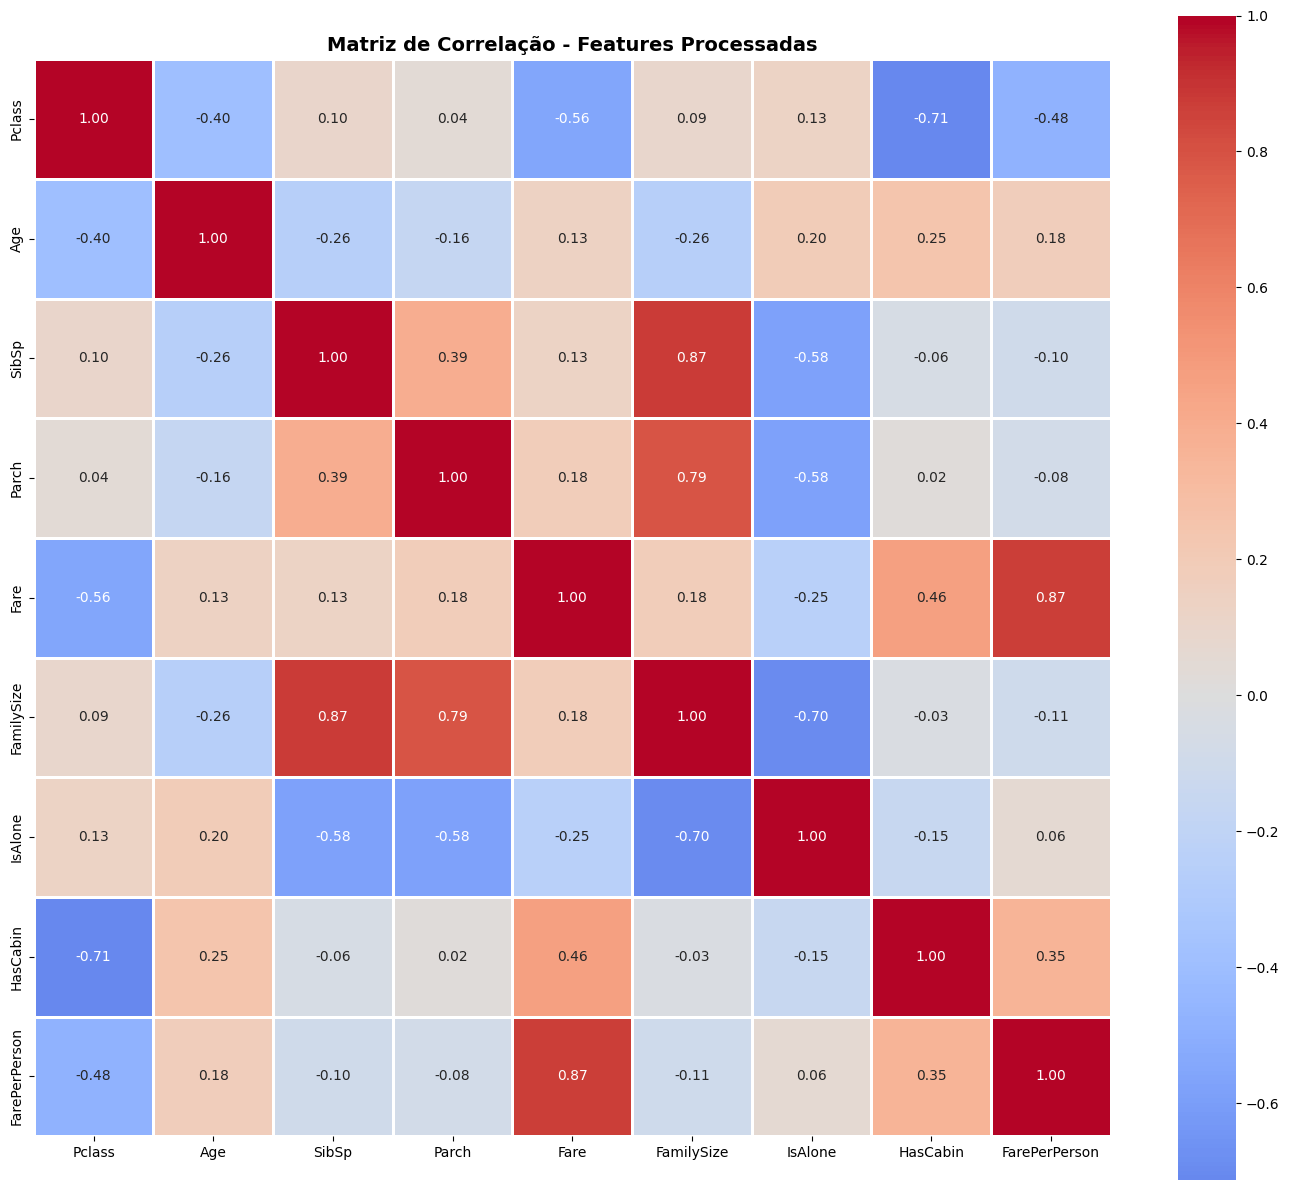

In [24]:
plt.figure(figsize=(14, 12))
correlation_matrix = X_train[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1)
plt.title('Matriz de Correlação - Features Processadas', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, '06_correlacao_processadas.png'), dpi=300, bbox_inches='tight')
print("✓ Matriz de correlação salva: 06_correlacao_processadas.png")


 # RESUMO FINAL